In [1]:
import utils
import pickle
import joblib
import sys, os
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
sys.path.append(os.path.abspath(os.path.join("..")))
sys.path.append(os.path.abspath(os.path.join('.','./CMAPSSData/')))
import matplotlib.pyplot as plt

In [2]:
from utils import rename_col, add_rul, minmax_dic, minmax_scl,smooth, smoothing, drop_org, LSTMRegressor, n_hidden_units, test, test_model, device
import torch

df_test = pd.read_csv("/home/kingos82/Fourthbrain/BoozAllen/CMAPSSData/test_FD001.txt", header=None, sep = ' ')
df_train = pd.read_csv("/home/kingos82/Fourthbrain/BoozAllen/CMAPSSData/train_FD001.txt", header=None, sep = ' ')



## Refactor data wrangling commands
df_train=rename_col(df_train)
df_test=rename_col(df_test)

df_train=add_rul(df_train, 'train')
df_test=add_rul(df_test, 'test')


#Drop os3, s1, s5, s6, s10, s16, s18, s19 from both train and test

drop_cols1 = ['os3','s1','s5','s6','s10','s16','s18','s19']
df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

#minmax scale the sensor values
minmax_dict=minmax_dic(df_train)
df_train=minmax_scl(df_train, minmax_dict)
df_test=minmax_scl(df_test, minmax_dict)

#smoothing the training & test data
df_train=smoothing(df_train)
df_test=smoothing(df_test)

#drop original data
df_train=drop_org(df_train)
df_test=drop_org(df_test)

# Instantiate the model
n_features = len([c for c in df_train.columns if 's' in c])
loaded_model = LSTMRegressor(n_features, n_hidden_units)

# Load the saved state_dict
model_path = "/home/kingos82/Fourthbrain/BoozAllen/model2140_1.pt"
loaded_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [3]:
    # Preparing Training, Validation and Test Dataloaders

eng_num=df_test['unit'].max()+1
units = np.arange(1,eng_num)

test_data = test(units, df_test)

torch.manual_seed(5)

testloader = DataLoader(test_data, batch_size = 100)

In [4]:

mse, l1, y_pred, y = test_model(loaded_model, testloader, device)

In [5]:
df_RUL = pd.read_csv('/home/kingos82/Fourthbrain/BoozAllen/CMAPSSData/RUL_FD001.txt', header=None, sep = ' ')
y=df_RUL[0].to_list()

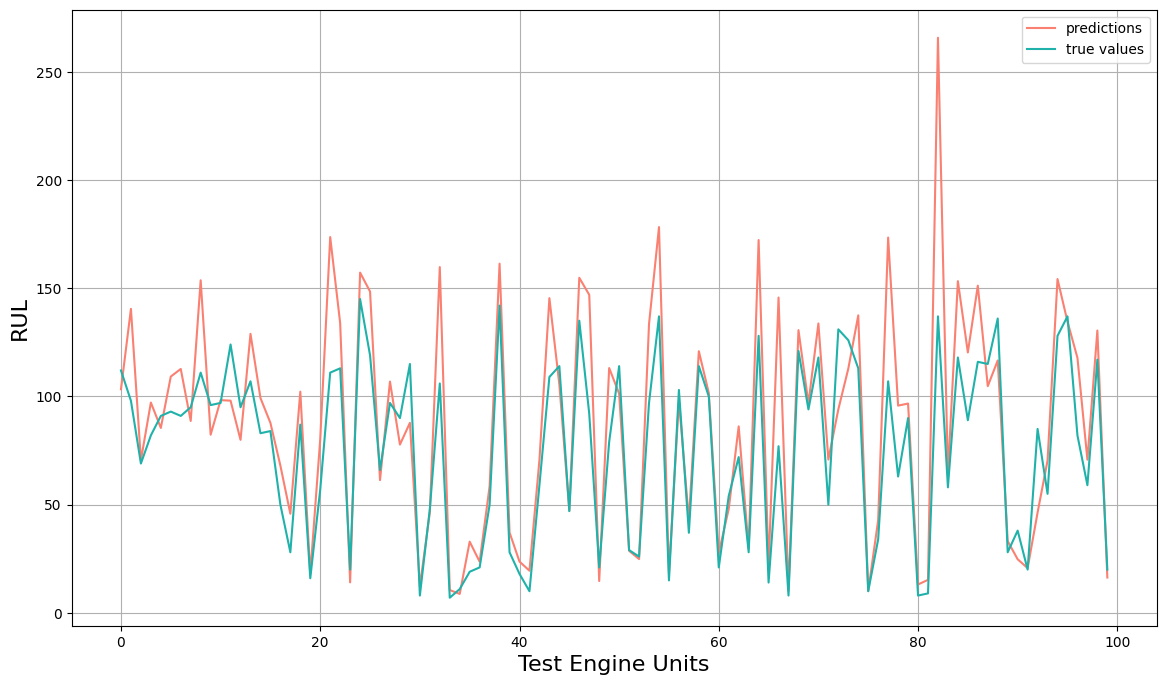

In [8]:
fig, ax = plt.subplots(figsize = (14,8))
ax.plot(np.arange(len(y_pred)), y_pred.numpy(), label = 'predictions', c = 'salmon')
ax.plot(np.arange(len(y)), y, label = 'true values', c = 'lightseagreen')
ax.set_xlabel('Test Engine Units', fontsize = 16)
ax.set_ylabel('RUL', fontsize = 16)
ax.grid(True)
ax.legend()
plt.show()

In [12]:

import plotly.graph_objects as go
def plt_rlu(y, y_pred):
    fig = go.Figure()

    fig.add_trace(
    go.Scatter(
        x =np.arange(len(y_pred)),
        y = y_pred,
        mode = 'lines', # Change the mode in this section!
        name='prediction'
        )
    )

    fig.add_trace(
    go.Scatter(
        x =np.arange(len(y)),
        y = y,
        mode = 'lines', # Change the mode in this section!
        name='True'
        )
    )
    return fig